### Description
The purpose of this notebook is to look at the distribution of the number of words in the cleaned text strings that were scraped for each SNP. Based on this, this notebook also looks at how all of the unique texts in this dataset should be grouped and blocked into surveys if an additional text cleaning step is necessary. For example, this notebook figures out how, given a certain number of participants, the text instances should be separated and how many of each category would be presented to a given participant.

In [1]:
import pandas as pd
import seaborn as sn
import math
import re
import os
from nltk import word_tokenize

In [2]:
# Takes
IDS_AND_UNIQUE_TEXTS_PATH = os.path.join("..","data","4_ids_and_unique_texts.csv")

# Creates
#SURVEY_TAG = "part_1"
SURVEY_TAG = "part_2"
BIN_BLOCK_RELATIONSHIPS_PATH = os.path.join("..","data","5_{}_bin_and_block_relationships.csv".format(SURVEY_TAG))
BINNED_AND_BLOCKED_TEXTS_PATH = os.path.join("..","data","6_{}_binned_and_blocked_texts.csv".format(SURVEY_TAG))

In [3]:
# Load the dataset of unique texts.
df = pd.read_csv(IDS_AND_UNIQUE_TEXTS_PATH)
print(df.shape)
df.head(20)

(5451, 2)


,id,text
0,1,"rs28936679, also known as Ala129Thr or A129T (..."
1,2,Genetic differences in human circadian clock g...
2,3,Genetic differences in human circadian clock g...
3,4,The -14C->T polymorphism rs1800977 of the ABCA...
4,5,Apolipoprotein E levels in cerebrospinal fluid...
5,6,"rs2297404, rs2230808, and rs2020927 haplotype ..."
6,7,Apolipoprotein E levels in cerebrospinal fluid...
7,8,Apolipoprotein E levels in cerebrospinal fluid...
8,9,"rs2230806, also known as Arg219Lys or R219K, i..."
9,10,"rs2297404, rs2230808, and rs2020927 haplotype ..."


In [4]:
# Optional step. Load up some previous results and subset these texts based on one's that haven't been seen enough.
previous_result_path = "../data/S301881_number_of_annotations_per_id_09_25_2020_h23m31s22.csv"
previous_result_df = pd.read_csv(previous_result_path)
ids_to_retain = list(previous_result_df[previous_result_df["num_highlights"]<2]["id"].values)
print(len(ids_to_retain))
df = df[df["id"].isin(ids_to_retain)]
print(df.shape)
df.head(20)

2958
(2958, 2)


,id,text
0,1,"rs28936679, also known as Ala129Thr or A129T (..."
2,3,Genetic differences in human circadian clock g...
7,8,Apolipoprotein E levels in cerebrospinal fluid...
11,12,Examining the effect of linkage disequilibrium...
13,14,C allele is associated with 1.51mg/dl increase...
15,16,aka c.7093G>A (p.Asp2365Asn)The variant allele...
16,17,aka c.316C>T
17,18,"rs149989682, also known as c.875A>T, p.Glu292V..."
19,20,"A 2013 meta-analysis comprising a total of ~2,..."
22,23,rs4147929 is a SNP in the ATP-binding cassette...


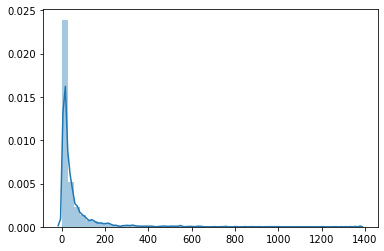

In [5]:
# Look at what the distribution is across these texts in terms of number of words.
word_num_distribution = [len(word_tokenize(x)) for x in df["text"].values]
sn.distplot(word_num_distribution)

In [6]:
# Specify n bin edges here, and then from those a set of n-1 bins are defined and used throughout the notebook.
# The lower edges will be inclusive and the upper edges will be exclusive.
# What do we want to choose for these values as well?

# These were the values that were used for part 1 of the survey.
#THRESHOLDS = [0, 10, 100, 1000, 3000]
#NUM_SURVEYS = 50
#MAX_BLOCK_SIZE = 300

# These were the values that were used for part 2 of the survey.
THRESHOLDS = [0, 10, 100, 500, 3000]
NUM_SURVEYS = 50
MAX_BLOCK_SIZE = 300

In [7]:
# Create the set of IDs for the bins and also tuples that reference the edges of each bin.
bin_ids_list = list(range(1,len(THRESHOLDS)))
bounds_list = [(lower,upper) for lower,upper in zip(THRESHOLDS[0:len(THRESHOLDS)-1], THRESHOLDS[1:len(THRESHOLDS)])]
print(bin_ids_list)
print(bounds_list)

[1, 2, 3, 4]
[(0, 10), (10, 100), (100, 500), (500, 3000)]


In [8]:
# Add a column indicating the number of words in each text.
df["num_words"] = df["text"].map(lambda x: len(word_tokenize(x)))
df.sort_values(by=["num_words"], ascending=True, inplace=True)
df.head(10)

,id,text,num_words
2058,2059,rs5030869,1
3516,3517,gs252,1
3501,3502,rs121434260,1
3500,3501,rs121434259,1
3499,3500,rs74315493,1
584,585,rs137852870,1
3498,3499,rs74315494,1
3497,3498,rs74315495,1
3496,3497,rs74315496,1
3495,3496,rs74315497,1


In [9]:
# Some of the text values with only one word are just SNP identifiers, and can be removed for the purposes of surveys.
snp_identifier_pattern = re.compile("rs[0-9]+")
is_snp_identifier = lambda s: bool(snp_identifier_pattern.match(s.lower()))
df["valid"] = df.apply(lambda row: is_snp_identifier(row["text"])==False or row["num_words"]>1, axis=1)
df = df[df["valid"]]
df = df[["id","text","num_words"]]
print(df.shape)

# Is there anything else that we can immediately remove from surveys, like very short text strings?
valid_indices = df['text'].apply(lambda x: len(x)>2)
df = df.loc[valid_indices, ["id","text","num_words"]]
print(df.shape)

(2590, 3)
(2588, 3)


In [10]:
df.head(20)

,id,text,num_words
3516,3517,gs252,1
1913,1914,Achondroplasiars75790268,1
1912,1913,Achondroplasiars121913105,1
1910,1911,Achondroplasiars121913114,1
3699,3700,Phenylketonuriars5030859,1
539,540,c.348-9_351del,1
3707,3708,Phenylketonuriars62516092,1
3708,3709,Phenylketonuriars62514953,1
3638,3639,freckling,1
3701,3702,Phenylketonuriars62514952,1


In [11]:
# The x value should be a particular integer, and the ranges should be a list of tuples of lower and upper bounds.
in_range = lambda x,bounds: (x>=bounds[0] and x<bounds[1])
in_ranges = lambda x,list_of_bounds_tuples: [in_range(x,bounds) for bounds in list_of_bounds_tuples]

# This is a helpful function needed for finding the index of the single true value in a boolean list.
def index_of_true_value_in_list(bool_list):
    assert sum(bool_list) == 1
    return([i for i,x in enumerate(bool_list) if x][0])

# Add a column indicating the ID for the bin that each text belongs in based on the number of words.
df["bin_id"] = df["num_words"].map(lambda x: bin_ids_list[index_of_true_value_in_list(in_ranges(x,bounds_list))])
df.head(10)

,id,text,num_words,bin_id
3516,3517,gs252,1,1
1913,1914,Achondroplasiars75790268,1,1
1912,1913,Achondroplasiars121913105,1,1
1910,1911,Achondroplasiars121913114,1,1
3699,3700,Phenylketonuriars5030859,1,1
539,540,c.348-9_351del,1,1
3707,3708,Phenylketonuriars62516092,1,1
3708,3709,Phenylketonuriars62514953,1,1
3638,3639,freckling,1,1
3701,3702,Phenylketonuriars62514952,1,1


In [12]:
# Obtain the one-to-many mapping from bin IDs to the IDs for each unique piece of text in the dataset.
bin_ids_to_text_ids = dict(df.groupby("bin_id")["id"].apply(list))
bin_ids_to_bin_quantities = {bin_id:len(text_ids) for bin_id,text_ids in bin_ids_to_text_ids.items()}


text_ids_to_block_ids = {}
FIRST_BLOCK_ID = 1
block_id = FIRST_BLOCK_ID

for bin_id,bin_qty in bin_ids_to_bin_quantities.items():
    
    # Figuring out how many blocks are needed to cover this bin and how large each should be.
    num_blocks_needed = math.ceil(bin_qty/MAX_BLOCK_SIZE)
    block_ids = range(block_id, block_id+num_blocks_needed)
    min_block_size = math.floor(bin_qty/num_blocks_needed)
    block_sizes = [min_block_size]*num_blocks_needed
    leftovers = bin_qty-sum(block_sizes)
    for i in range(leftovers):
        block_sizes[i] = block_sizes[i]+1
        
    # Make a mapping between all the text IDs for everything in this bin to corresponding new block IDs.
    block_id_long_list = []
    for block_id,block_size in zip(block_ids,block_sizes):
        block_id_long_list.extend([block_id]*block_size)
    text_ids_to_block_ids_inner = {text_id:block_id for text_id,block_id in zip(bin_ids_to_text_ids[bin_id],block_id_long_list)}
    text_ids_to_block_ids.update(text_ids_to_block_ids_inner)
    block_id = max(block_ids)+1

# Add the column for block IDs, and figure out the number of texts in each bin and block.
df["block_id"] = df["id"].map(text_ids_to_block_ids)
df["block_size"] = df["block_id"].map(dict(df.groupby("block_id").size()))
df["bin_size"] = df["bin_id"].map(dict(df.groupby("bin_id").size()))
df["block_sample"] = df["block_size"].map(lambda x: math.ceil(x/NUM_SURVEYS))
df = df[["id","text","bin_id","bin_size","block_id","block_size","block_sample"]]
df.to_csv(os.path.join(BINNED_AND_BLOCKED_TEXTS_PATH), index=False)
df.head(20)

,id,text,bin_id,bin_size,block_id,block_size,block_sample
3516,3517,gs252,1,771,1,257,6
1913,1914,Achondroplasiars75790268,1,771,1,257,6
1912,1913,Achondroplasiars121913105,1,771,1,257,6
1910,1911,Achondroplasiars121913114,1,771,1,257,6
3699,3700,Phenylketonuriars5030859,1,771,1,257,6
539,540,c.348-9_351del,1,771,1,257,6
3707,3708,Phenylketonuriars62516092,1,771,1,257,6
3708,3709,Phenylketonuriars62514953,1,771,1,257,6
3638,3639,freckling,1,771,1,257,6
3701,3702,Phenylketonuriars62514952,1,771,1,257,6


In [13]:
# What is the relationship between the bin IDs and the block IDs?
blocks_df = pd.DataFrame(df.drop_duplicates(subset=["block_id"], inplace=False))
blocks_df = blocks_df[["bin_id", "bin_size", "block_id", "block_size", "block_sample"]]
blocks_df.sort_values(by=["bin_id","block_id"], inplace=True)
blocks_df.reset_index(drop=True, inplace=True)
blocks_df.to_csv(BIN_BLOCK_RELATIONSHIPS_PATH, index=False)
blocks_df

,bin_id,bin_size,block_id,block_size,block_sample
0,1,771,1,257,6
1,1,771,2,257,6
2,1,771,3,257,6
3,2,1468,4,294,6
4,2,1468,5,294,6
5,2,1468,6,294,6
6,2,1468,7,293,6
7,2,1468,8,293,6
8,3,310,9,155,4
9,3,310,10,155,4


In [14]:
# If splitting into bins, blocks, and sampling was done that way, what would the content for one survey look like?
bin_id_to_num_texts_per_survey = dict(blocks_df.groupby("bin_id")["block_sample"].sum())
for bin_id,bounds in zip(bin_ids_list, bounds_list):
    num_texts = bin_id_to_num_texts_per_survey[bin_id]
    lower = bounds[0]
    upper = bounds[1]
    print("{} texts ranging from {} to {} words long.".format(num_texts, lower, upper))

18 texts ranging from 0 to 10 words long.
30 texts ranging from 10 to 100 words long.
8 texts ranging from 100 to 500 words long.
1 texts ranging from 500 to 3000 words long.
